In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.svm import SVC
import operator
import googlefinance.client as gfc
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import quandl

%matplotlib notebook

The goal of this notebook is to create time series regression models using some regression models as well as "Forest" models (both regression and deep learning versions). 

The features for this part of the research are going to be extracted using data freely available in Python via Quandl and pandas Yahoo finance support. 

- NASDAQ Composite
- Dow Jones Industrial Average
- Frankfurt DAX
- London FTSE-100
- Paris CAC 40
- Tokyo Nikkei-225
- Hong Kong Hang Seng
- Australia ASX-200

The features will be extracted from the major market indicators above will have the following format:

- Date : in days

- Open : price of the stock at the opening of the trading (in US dollars)
- High : highest price of the stock during the day (in US dollars)
- Low : lowest price of the stock during the trading day (in US dollars)
- Close : price of the stock at the closing of the trading (in US dollars)
- Volume : amount of stocks traded (in US dollars)
- Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

In [88]:
# Get googlefinance major global ETF data

period = "12M"

params = [
    {'q': "IXIC",
     'x': 'INDEXNASDAQ'
    },
    {'q': '.DJI',
      'x': 'INDEXDJX'  
    },
    {'q':'DAX',
     'x':'INDEXDB'   
    },
    {'q': 'UKX',
      'x':'INDEXFTSE'   
    },
    {'q': 'PX1',
      'x': 'INDEXEURO'   
    },
    {'q': 'NI225',
      'x': 'INDEXNIKKEI'  
    },
    {'q': 'HSI',
      'x': 'INDEXHANGSENG'  
    },
    {'q': 'XJO',
      'x':'INDEXASX'   
    },
    {'q': "SPY",
     'x': 'NYSEARCA'
    }
]
feats1 = gfc.get_prices_data(params, period)
# Clear the null volume data
j = feats1.pop('IXIC_Volume')
j = feats1.pop('XJO_Volume')
feats1.shape

(262, 43)

In [89]:
feats1.index

Index([2016-08-30, 2016-08-31, 2016-09-01, 2016-09-02, 2016-09-05, 2016-09-06,
       2016-09-07, 2016-09-08, 2016-09-09, 2016-09-12,
       ...
       2017-08-17, 2017-08-18, 2017-08-21, 2017-08-22, 2017-08-23, 2017-08-24,
       2017-08-25, 2017-08-28, 2017-08-29, 2017-08-30],
      dtype='object', length=262)

<IPython.core.display.Javascript object>


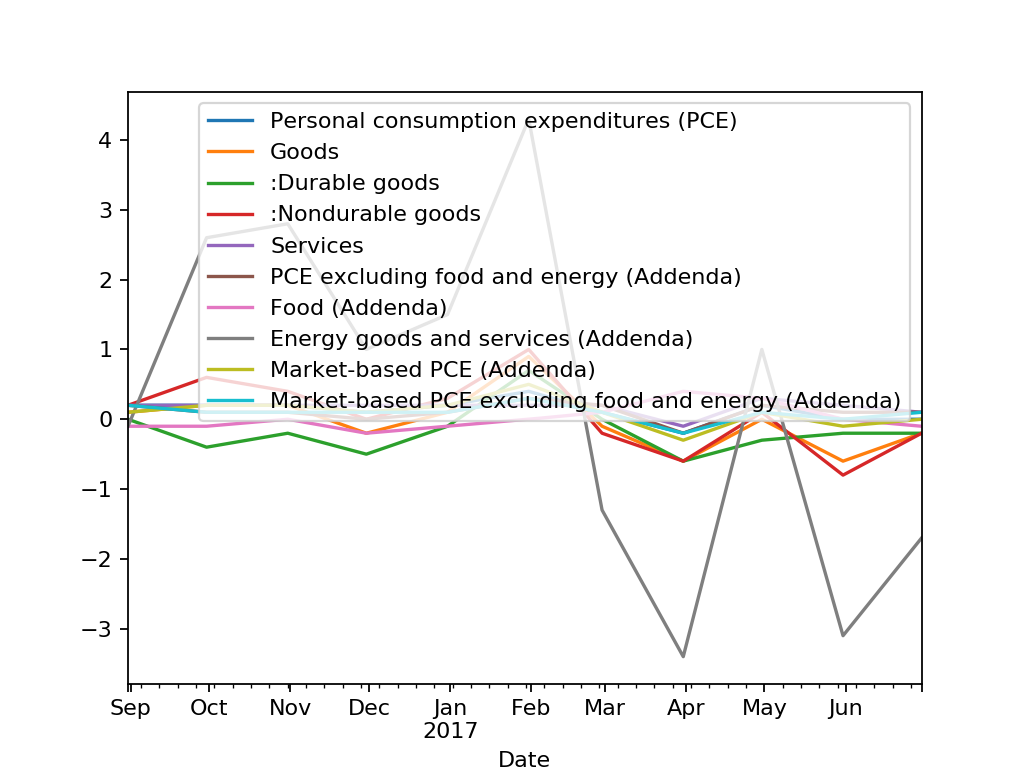

In [90]:
quandl.ApiConfig.api_key = "a1LZ4iFxZS6mzZUsf28u"
feats2 = quandl.get('BEA/NIPA_2_8_7_M', start_date='2016-08-30',
                   end_date='2017-08-30')
feats2 = feats2.resample('1D')

feats2 = feats2.interpolate('time')
feats2.plot()


In [93]:
# Merge data
feats1['tmp'] = 1
feats2['tmp'] = 1
feats1.merge(feats2, on=['tmp'])
feats1 = feats1.drop('tmp', axis=1)

In [94]:
# Percentage diff of adjusted cose price to 3 days ago
# returns = df.pct_change()
#df['pct_change'] = df.price.pct_change()
# df['log_return'] = np.log(1 + df.pct_change)

returns = feats1 - feats1.shift(1)

#gret = np.log(1 + ret)

In [95]:
feature_keys = []
target_keys = []
for i in feats1.columns:
    if 'SPY' in i:
        if 'Close' in i:
            target_keys.append(i)
    else:
        feature_keys.append(i)

In [96]:
returns = returns.dropna()
X = returns[feature_keys][0:-1]
y = returns[target_keys][1:]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [98]:
print(y_train.shape)

(126, 1)


# Ordinary Least Square

<IPython.core.display.Javascript object>


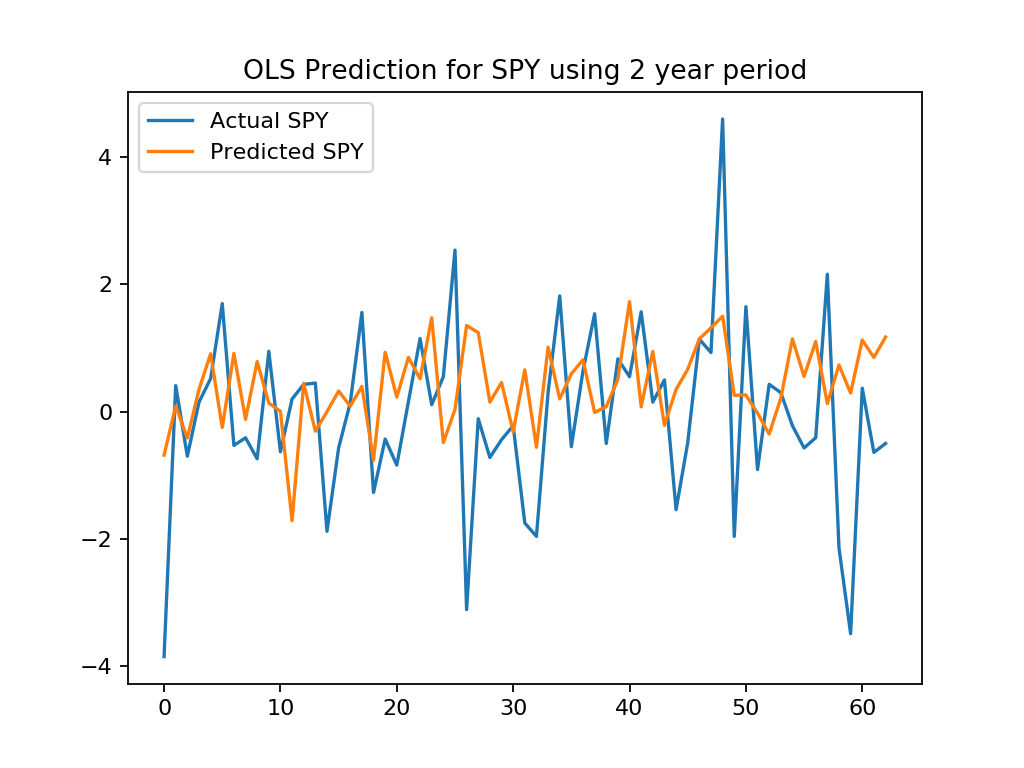

-0.20120715080642038

In [99]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_predicted = reg.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('OLS Prediction for SPY using 2 year period')
plt.legend()


reg.score(X_test, y_test)

# RidgeCV Method

<IPython.core.display.Javascript object>


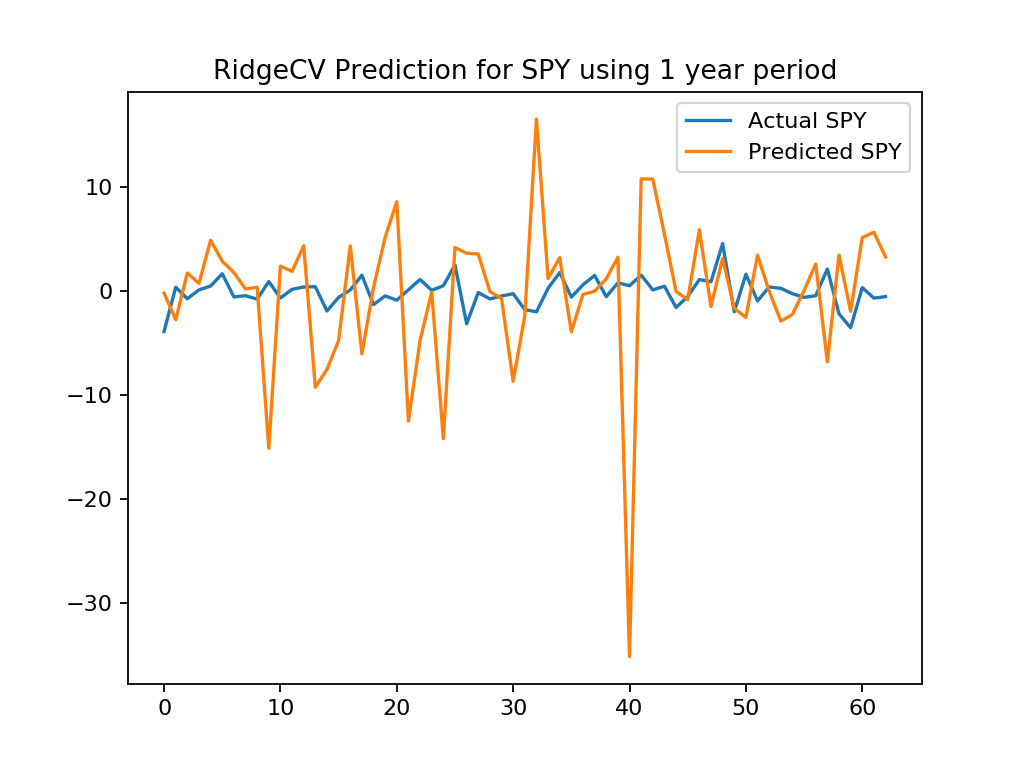

-26.634308421317986

In [100]:
ridge = linear_model.RidgeCV()
ridge.fit(X_train, y_train)
y_ridge_predicted = ridge.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_ridge_predicted, label='Predicted SPY')
ax.set_title('RidgeCV Prediction for SPY using 1 year period')
plt.legend()

ridge.score(X_test, y_test)

# Lasso 

<IPython.core.display.Javascript object>


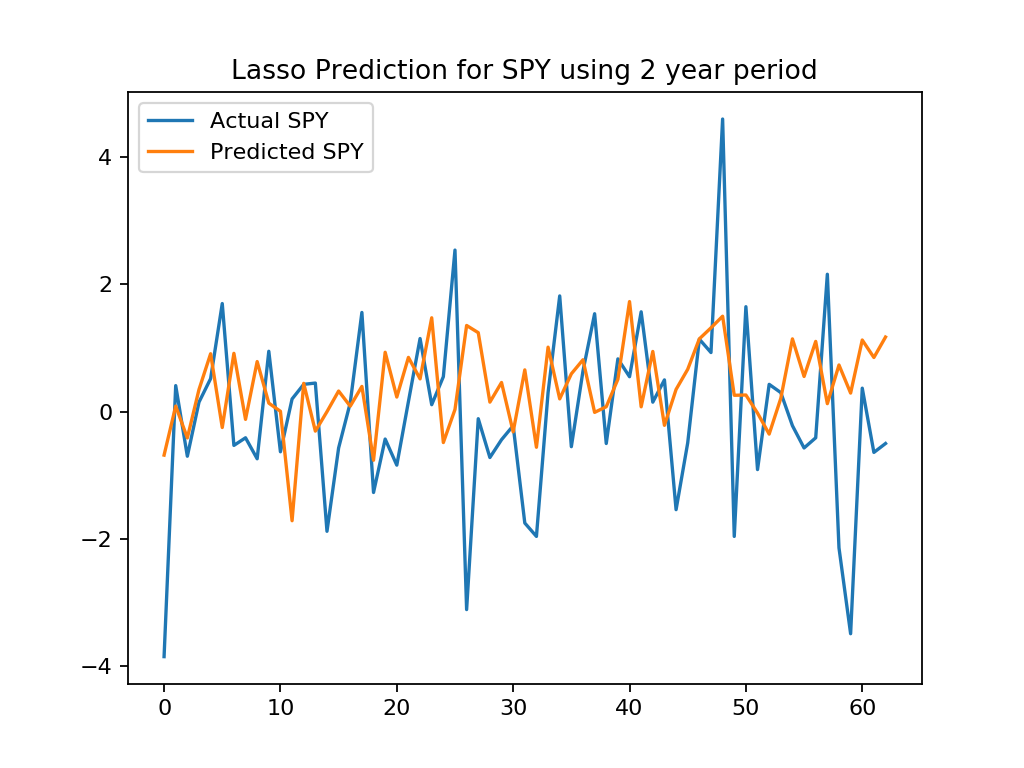

-0.20120828673218805

In [59]:
lasso = linear_model.Lasso(alpha = 1e-5)
lasso.fit(X_train, y_train)

y_predicted = lasso.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('Lasso Prediction for SPY using 2 year period')
plt.legend()


lasso.score(X_test, y_test)

# Random Forest Regressor

/Users/armanarkilic/anaconda/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


<IPython.core.display.Javascript object>


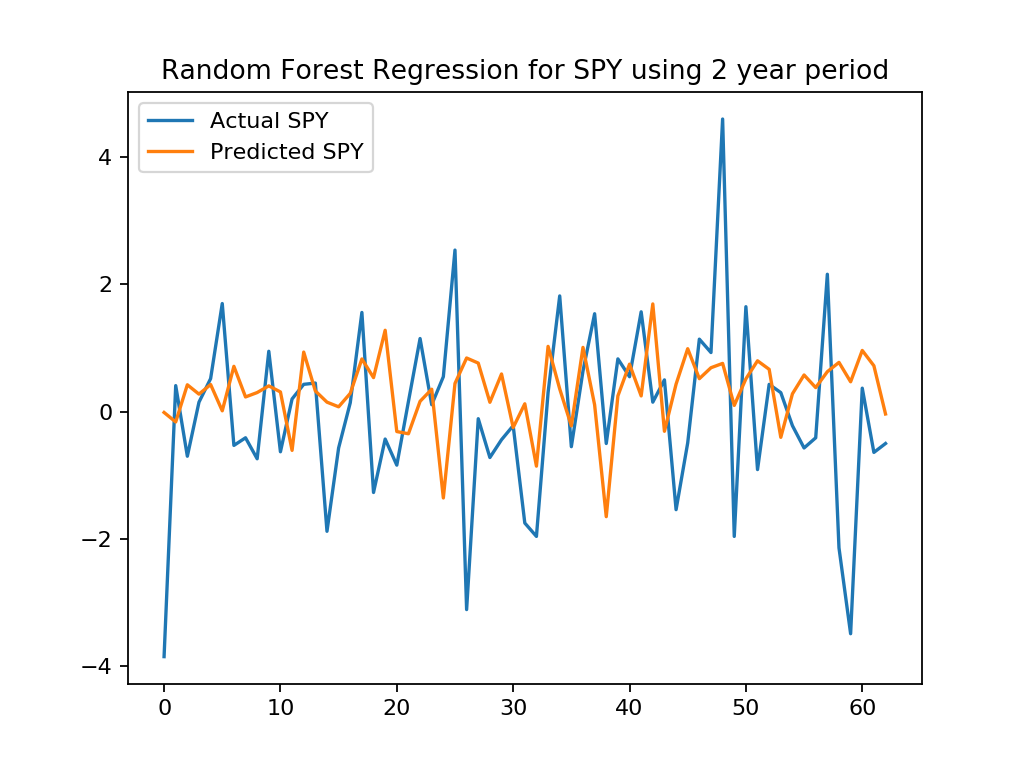

-0.1530841865411996

In [65]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
regr_predicted = regr.predict(X_test)
fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(regr_predicted, label='Predicted SPY')
ax.set_title('Random Forest Regression for SPY using 2 year period')
plt.legend()

regr.score(X_test, y_test)


In [16]:
y.head()

,SPY_Close
2016-09-02,0.9800
2016-09-07,-0.0208
2016-09-08,-0.5000
2016-09-09,-5.2300
2016-09-12,3.0600
